In [1]:
import sys
import os
import re
import pickle
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from transformers import TFBertModel,BertTokenizer
from sklearn.preprocessing import StandardScaler
import sys
import os
import re
import pickle


DATA_PATH = '../data/MOSEI/'

def to_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def get_length(x):
    return x.shape[1]-(np.sum(x, axis=-1) == 0).sum(1)

# first we align to words with averaging, collapse_function receives a list of functions
# dataset.align(text_field, collapse_functions=[avg])
# load pickle file for unaligned acoustic and visual source
pickle_filename = DATA_PATH+'mosei_senti_data_noalign.pkl'
csv_filename = DATA_PATH+'MOSEI-label.csv'

with open(pickle_filename, 'rb') as f:
    d = pickle.load(f)

# read csv file for label and text
df = pd.read_csv(csv_filename)
text = df['text']
vid = df['video_id']
cid = df['clip_id']

train_split_noalign = d['train']
dev_split_noalign = d['valid']
test_split_noalign = d['test']

# a sentinel epsilon for safe division, without it we will replace illegal values with a constant
EPS = 1e-6

# place holders for the final train/dev/test dataset
train = train = []
dev = dev = []
test = test = []

# define a regular expression to extract the video ID out of the keys
# pattern = re.compile('(.*)\[.*\]')
pattern = re.compile('(.*)_([.*])')
num_drop = 0 # a counter to count how many data points went into some processing issues

v = np.concatenate((train_split_noalign['vision'],dev_split_noalign['vision'], test_split_noalign['vision']),axis=0)
vlens = get_length(v)

a = np.concatenate((train_split_noalign['audio'],dev_split_noalign['audio'], test_split_noalign['audio']),axis=0)
alens = get_length(a)

label = np.concatenate((train_split_noalign['labels'],dev_split_noalign['labels'], test_split_noalign['labels']),axis=0)

L_V = v.shape[1]
L_A = a.shape[1]


all_id = np.concatenate((train_split_noalign['id'], dev_split_noalign['id'], test_split_noalign['id']),axis=0)[:,0]
all_id_list = all_id.tolist()

train_size = len(train_split_noalign['id'])
dev_size = len(dev_split_noalign['id'])
test_size = len(test_split_noalign['id'])

dev_start = train_size
test_start = train_size + dev_size

all_csv_id = [(vid[i], str(cid[i])) for i in range(len(vid))]

for i, idd in enumerate(all_id_list):
    # get the video ID and the features out of the aligned dataset

    # matching process
    try:
        index = i
    except:
        import ipdb; ipdb.set_trace()

    _words = text[index].split()
    _label = label[i].astype(np.float32)
    _visual = v[i]
    _acoustic = a[i]
    _vlen = vlens[i]
    _alen = alens[i]
    _id = '{}[{}]'.format(all_csv_id[0], all_csv_id[1])           

    # remove nan values
    # label = np.nan_to_num(label)
    _visual = np.nan_to_num(_visual)
    _acoustic = np.nan_to_num(_acoustic)

    # remove speech pause tokens - this is in general helpful
    # we should remove speech pauses and corresponding visual/acoustic features together
    # otherwise modalities would no longer be aligned
    actual_words = []
    words = []
    visual = []
    acoustic = []

    for word in _words:
        actual_words.append(word)

    visual = _visual[L_V - _vlen:,:]
    acoustic = _acoustic[L_A - _alen:,:]

    if i < dev_start:
        train.append((words, visual, acoustic, actual_words, _vlen, _alen, _label, idd))
    elif i >= dev_start and i < test_start:
        dev.append((words, visual, acoustic, actual_words, _vlen, _alen, _label, idd))
    elif i >= test_start:
        test.append((words, visual, acoustic, actual_words, _vlen, _alen, _label, idd))
    else:
        print(f"Found video that doesn't belong to any splits: {idd}")


# print(f"Total number of {num_drop} datapoints have been dropped.")
print(f"Total number of {num_drop} datapoints have been dropped.")
print("Dataset split")
print("Train Set: {}".format(len(train)))
print("Validation Set: {}".format(len(dev)))
print("Test Set: {}".format(len(test)))

# Save glove embeddings cache too
# self.pretrained_emb = pretrained_emb = load_emb(word2id, config.word_emb_path)
# torch.save((pretrained_emb, word2id), CACHE_PATH)
pretrained_emb = None

# Save pickles
to_pickle(train, DATA_PATH + '/dftrain.pkl')
to_pickle(dev, DATA_PATH + '/dfdev.pkl')
to_pickle(test, DATA_PATH + '/dftest.pkl')

Total number of 0 datapoints have been dropped.
Dataset split
Train Set: 16326
Validation Set: 1871
Test Set: 4659


In [2]:
train_df = pd.DataFrame(train,columns=['words', 'visual', 'acoustic', 'actual_words', '_vlen', '_alen', '_label', 'idd'])
dev_df = pd.DataFrame(dev,columns=['words', 'visual', 'acoustic', 'actual_words', '_vlen', '_alen', '_label', 'idd'])
test_df = pd.DataFrame(test,columns=['words', 'visual', 'acoustic', 'actual_words', '_vlen', '_alen', '_label', 'idd'])


In [65]:
# train_df.to_csv('train_df.csv')
# dev_df.to_csv('dev_df.csv')
# test_df.to_csv('test_df.csv')

In [66]:
train_df

,words,visual,acoustic,actual_words,_vlen,_alen,_label,idd
0,Key is part of the people that we use to solve...,"[[-1.2108299732208252, -0.46178698539733887, -...","[[194.5, 0.0, 0.07899338752031326, 0.412973552...","[Key, is, part, of, the, people, that, we, use...",267,356,[[1.0]],-3g5yACwYnA
1,They've been able to find solutions or at leas...,"[[-1.7858200073242188, -0.6380839943885803, 0....","[[105.5, 1.0, 0.021022265776991844, 0.08599962...","[They've, been, able, to, find, solutions, or,...",81,107,[[0.6666667]],-3g5yACwYnA
2,We're a huge user of adhesives for our operati...,"[[-1.7642099857330322, -0.7958599925041199, -0...","[[106.5, 1.0, 0.11148008704185486, 0.726543664...","[We're, a, huge, user, of, adhesives, for, our...",215,286,[[0.0]],-3g5yACwYnA
3,Key Polymer brings a technical aspect to our o...,"[[-1.2986199855804443, -0.2510870099067688, -0...","[[115.5, 1.0, 0.057251088321208954, 0.33875322...","[Key, Polymer, brings, a, technical, aspect, t...",138,184,[[0.0]],-3g5yACwYnA
4,Key brings those types of aspects to a busines...,"[[-1.6502399444580078, -0.3371959924697876, -0...","[[100.5, 1.0, 0.14517584443092346, 0.675116181...","[Key, brings, those, types, of, aspects, to, a...",221,295,[[1.0]],-3g5yACwYnA
...,...,...,...,...,...,...,...,...
16321,"I read other articles, what other trainers in ...","[[-1.8842400312423706, -0.6028929948806763, 0....","[[127.5, 1.0, 0.11853820085525513, 0.720579862...","[I, read, other, articles,, what, other, train...",72,103,[[0.0]],zwTrXwi54us
16322,I do all of that,"[[-2.153140068054199, -0.04792049899697304, -0...","[[129.5, 1.0, 0.1991356760263443, 0.6945900321...","[I, do, all, of, that]",28,37,[[0.0]],zwTrXwi54us
16323,"Now, if this sounds like something you're inte...","[[-4.401090145111084, -1.0127899646759033, -1....","[[188.5, 0.0, 0.05910159647464752, 0.331484466...","[Now,, if, this, sounds, like, something, you'...",163,227,[[0.6666667]],zwTrXwi54us
16324,I actually speak to the experts myself to give...,"[[-2.3272500038146973, -1.1171799898147583, 0....","[[133.0, 0.0, 0.027281710878014565, 0.07664652...","[I, actually, speak, to, the, experts, myself,...",80,106,[[1.0]],zwTrXwi54us


In [67]:
dev_df

,words,visual,acoustic,actual_words,_vlen,_alen,_label,idd
0,I see that a writer is somebody who has an inc...,"[[-1.3421499729156494, -0.6688669919967651, -0...","[[114.0, 1.0, 0.04578984156250954, 0.118132553...","[I, see, that, a, writer, is, somebody, who, h...",107,142,[[1.0]],--qXJuDtHPw
1,"This is Rhett Reiger, White Caspian Studios on...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[This, is, Rhett, Reiger,, White, Caspian, Stu...",63,100,[[0.0]],-571d8cVauQ
2,"However, again on a low budget film there's no...","[[-0.2587659955024719, -0.8795980215072632, -0...","[[122.5, 0.0, 0.14841802418231964, 0.583313167...","[However,, again, on, a, low, budget, film, th...",97,129,[[-0.6666667]],-571d8cVauQ
3,"So very important to go out to the locations, ...","[[-0.46711400151252747, 0.2940419912338257, -0...","[[121.0, 1.0, 0.10455980896949768, 0.223736286...","[So, very, important, to, go, out, to, the, lo...",220,302,[[0.33333334]],-571d8cVauQ
4,In the United States we don't punish failure t...,"[[-2.4220099449157715, -1.6418999433517456, -1...","[[83.0, 0.0, 0.008974796161055565, 0.125849887...","[In, the, United, States, we, don't, punish, f...",112,148,[[-0.6666667]],-I_e4mIh0yE
...,...,...,...,...,...,...,...,...
1866,If you're in a very rural area you may or may ...,"[[-3.7082600593566895, -0.8364790081977844, -0...","[[178.0, 1.0, 0.14539840817451477, 0.663901090...","[If, you're, in, a, very, rural, area, you, ma...",145,193,[[-0.33333334]],zjYEBwXGD8I
1867,They also offer a 30-day money-back guarantee ...,"[[-4.890960216522217, -2.7805700302124023, -0....","[[234.0, 1.0, 0.08206792175769806, 0.240783601...","[They, also, offer, a, 30-day, money-back, gua...",106,154,[[0.33333334]],zjYEBwXGD8I
1868,You can see all of them on their website,"[[-4.55810022354126, -0.8051630258560181, -2.0...","[[120.0, 1.0, 0.15524542331695557, 0.629251360...","[You, can, see, all, of, them, on, their, webs...",38,51,[[0.33333334]],zjYEBwXGD8I
1869,They differ from the articles of incorporation...,"[[-2.6580300331115723, -3.101370096206665, -2....","[[77.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11802618205...","[They, differ, from, the, articles, of, incorp...",165,221,[[0.0]],zk2jTlAtvSU


In [68]:
test_df

,words,visual,acoustic,actual_words,_vlen,_alen,_label,idd
0,"So the answer to the question, can I contribut...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[160.0, 0.0, 0.015867682173848152, 0.12487309...","[So, the, answer, to, the, question,, can, I, ...",200,277,[[0.33333334]],-6rXp3zJ3kc
1,Many people are not until they get to be a old...,"[[1.0541399717330933, -0.9006710052490234, -0....","[[97.0, 1.0, 0.03028111532330513, 0.1211426928...","[Many, people, are, not, until, they, get, to,...",189,254,[[-1.0]],-6rXp3zJ3kc
2,And it's a retirement future that can ultimate...,"[[-0.6705549955368042, 1.479390025138855, -1.4...","[[109.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0817483589...","[And, it's, a, retirement, future, that, can, ...",126,168,[[0.0]],-6rXp3zJ3kc
3,"It’s so nice, by giving a good example and not...","[[-2.5768799781799316, -0.6222079992294312, -1...","[[224.0, 0.0, 0.10835210233926773, 0.372192740...","[It’s, so, nice,, by, giving, a, good, example...",92,122,[[1.3333334]],-9y-fZ3swSY
4,"is, you can say, hey I really like baby skin, ...","[[-3.5167899131774902, -0.38781800866127014, -...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[is,, you, can, say,, hey, I, really, like, ba...",101,135,[[1.0]],-9y-fZ3swSY
...,...,...,...,...,...,...,...,...
4654,"And yet, it's like, how a/Autistic people defe...","[[-4.255650043487549, -6.408750057220459, -1.1...","[[397.0, 0.0, 0.10553906112909317, 0.244144722...","[And, yet,, it's, like,, how, a/Autistic, peop...",65,86,[[0.0]],zhNksSReaQk
4655,But the thing is that intelligence [scoffs] is...,"[[-4.138179779052734, -2.4890499114990234, -1....","[[345.0, 0.0, 0.06806447356939316, 0.138989686...","[But, the, thing, is, that, intelligence, [sco...",117,155,[[-2.0]],zhNksSReaQk
4656,"They're like, ""Oh, they have a high IQ, they a...","[[-4.616549968719482, -4.315279960632324, -2.9...","[[310.5, 0.0, 0.1020767018198967, 0.2793643474...","[They're, like,, ""Oh,, they, have, a, high, IQ...",102,136,[[0.0]],zhNksSReaQk
4657,"If you're ready to strengthen your skills, whi...","[[-5.505410194396973, -8.764880180358887, -3.0...","[[262.0, 1.0, 0.18188852071762085, 0.531051397...","[If, you're, ready, to, strengthen, your, skil...",150,199,[[1.0]],zvZd3V5D5Ik


In [69]:
def create_acoustic_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1))(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)  # Add an additional Conv2D layer
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.Dense(128, activation='relu')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def create_video_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1))(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(x)  # Add an additional Conv2D layer
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.Dense(128, activation='relu')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x)

def create_bert_model(max_length):
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
    # bertconfig = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
    # bert_model = BertModel.from_pretrained('bert-base-uncased', config=bertconfig)
    
    # Use TFBertModel without specifying add_pooling_layer
    bert_model = TFBertModel.from_pretrained("bert-base-uncased")
    
    # Get the pooled output from BERT
    bert_output = bert_model(input_ids=input_ids, attention_mask=attention_mask)[1]
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=bert_output)


In [70]:


# Modify the create_combined_model function
def create_combined_model(acoustic_input_shape, visual_input_shape, text_max_length):
    acoustic_model = create_acoustic_model(acoustic_input_shape)
    bert_model = create_bert_model(text_max_length)
    video_model = create_video_model(visual_input_shape)

    input_ids = tf.keras.layers.Input(shape=(text_max_length,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input(shape=(text_max_length,), dtype=tf.int32)
    acoustic_input = tf.keras.layers.Input(shape=acoustic_input_shape)
    visual_input = tf.keras.layers.Input(shape=visual_input_shape)

    # Get the BERT embeddings sequence (output shape: batch_size, max_length, bert_output_dim)
    bert_output = bert_model([input_ids, attention_mask])

    # Assuming the output shape of your video_model is (batch_size, video_output_dim)
    visual_output = video_model(visual_input)

    # Assuming the output shape of your acoustic_model is (batch_size, acoustic_output_dim)
    acoustic_output = acoustic_model(acoustic_input)

    # Modify the next lines according to your actual requirements for combining the models
    # For example, flatten the video_output if needed
    visual_output = tf.keras.layers.Flatten()(visual_output)

    # Flatten the BERT embeddings sequence to match the visual_output's shape
    bert_output = tf.keras.layers.Flatten()(bert_output)

    # Concatenate the outputs of the three models
    combined_input = tf.keras.layers.Concatenate()([acoustic_output, bert_output, visual_output])
    # x = tf.keras.layers.Dense(500, activation='relu')(combined_input)
    # x = tf.keras.layers.Dense(250, activation='sigmoid')(x)
    x = tf.keras.layers.Dense(128, activation='sigmoid')(combined_input)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[acoustic_input, input_ids, attention_mask, visual_input], outputs=outputs)
    return model


In [71]:
np.shape(train_df['acoustic'][15])

(500, 74)

In [72]:
np.shape(train_df['visual'][15])

(500, 35)

In [73]:
# Encode text data using BERT tokenizer
def encode_text_data(text_data, max_length=500):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    input_ids = []
    attention_masks = []

    for text in text_data:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,  # Set max_length to 500 for BERT base model
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)

    return input_ids, attention_masks

def addPadding(df, colName, dim):
    max_length_x = df[colName].apply(lambda x: x.shape[0] if isinstance(x, np.ndarray) else 0).max()

    # Perform padding within the DataFrame
    df[colName] = df[colName].apply(lambda x: np.vstack([x, np.zeros((max_length_x - x.shape[0], dim))]) if isinstance(x, np.ndarray) else x)


def processText(text):
    return ' '.join(text)

def preprocessData(df):
    addPadding(df,'visual',35)
    addPadding(df,'acoustic',74)

    df['words'] = df['actual_words'].apply(processText)

    # Preprocess text data and create a tf.data.Dataset
    text_data = encode_text_data(df['words'].tolist())

    # Prepare the rest of the data
    acoustic_data = np.stack(df['acoustic'])
    visual_data = np.stack(df['visual'])
    label_data = np.array([label[0] for label in df['_label']])

    # Unpack the text_data into input_ids_data and attention_mask_data
    input_ids_data, attention_mask_data = text_data
    input_ids_data = input_ids_data.numpy().astype(np.int32)
    attention_mask_data = attention_mask_data.numpy().astype(np.int32)

    # Convert the label_data to float32 as it is expected for regression
    label_data = label_data.astype(np.float32)
    return {'Data':[acoustic_data, input_ids_data, attention_mask_data, visual_data],'Label_denorm':label_data}

In [74]:
model = create_combined_model(acoustic_input_shape=(500,74), visual_input_shape=(500,35), text_max_length=500)
modelTrainData = preprocessData(train_df)
modelValData = preprocessData(dev_df)
modelTestData = preprocessData(test_df)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [75]:
def flatten_2d_array(arr_2d):
    arr_1d = []
    for row in arr_2d:
        for item in row:
            arr_1d.append(item)
    return arr_1d
def minmax_normalize(arr, min_val, max_val):
    return (arr - min_val) / (max_val - min_val)
def minmax_denormalize(arr_normalized, min_val, max_val):
    return arr_normalized * (max_val - min_val) + min_val

In [76]:
all_arrays_label = np.vstack(flatten_2d_array(modelTrainData['Label_denorm']) + flatten_2d_array(modelValData['Label_denorm']) + flatten_2d_array(modelTestData['Label_denorm']))

# Calculate the overall label minimum and maximum values
label_min = np.min(all_arrays_label)
label_max = np.max(all_arrays_label)

print("Overall Label Minimum:", label_min)
print("Overall Label Maximum:", label_max)

Overall Label Minimum: -3.0
Overall Label Maximum: 3.0


In [77]:
modelTrainData['Label'] = np.array([[minmax_normalize(arr[0], label_min, label_max)] for arr in modelTrainData['Label_denorm']])
modelValData['Label'] = np.array([[minmax_normalize(arr[0], label_min, label_max)] for arr in modelValData['Label_denorm']])
modelTestData['Label'] = np.array([[minmax_normalize(arr[0], label_min, label_max)] for arr in modelTestData['Label_denorm']])

In [79]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(
    modelTrainData['Data'],
    modelTrainData['Label'],
    epochs=1,
    verbose=1,
    validation_data=(modelValData['Data'],modelValData['Label'])
)



2023-08-25 18:31:58.400265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - ETA: 0s - loss: 0.0350 - mean_absolute_error: 0.1411

2023-08-25 19:30:59.967139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - 3622s 7s/step - loss: 0.0350 - mean_absolute_error: 0.1411 - val_loss: 0.0284 - val_mean_absolute_error: 0.1273


In [80]:
predictions = model.predict(modelTestData['Data'])

2023-08-25 19:32:16.156007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 172s 1s/step


In [81]:
denormPred = np.array([[minmax_denormalize(arr[0], label_min, label_max)] for arr in predictions])

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score

def run_metrices(y_true, y_pred):

    # Computing metrics

    # Compute Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)

    # Compute Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)

    # Clean NaN values if present
    clean_mask = np.logical_and(~np.isnan(y_true), ~np.isnan(y_pred))
    y_true_cleaned = y_true[clean_mask]
    y_pred_cleaned = y_pred[clean_mask]

    # Calculate Pearson correlation
    corr_coeff = np.corrcoef(y_pred_cleaned, y_true_cleaned)[0, 1]

    # Define interval boundaries for Acc-7
    interval_boundaries = np.linspace(-3, 3, 8)

    # Categorize predictions into intervals
    y_true_intervals = np.digitize(y_true, interval_boundaries)
    y_pred_intervals = np.digitize(y_pred, interval_boundaries)

    # Compute Acc-7
    acc_7 = accuracy_score(y_true_intervals, y_pred_intervals)

    # Create binary labels for Acc-2 and F1 Score
    y_true_binary = np.where(y_true >= 0, 1, 0)
    y_pred_binary = np.where(y_pred >= 0, 1, 0)

    # Compute Acc-2
    acc_2 = accuracy_score(y_true_binary, y_pred_binary)

    # Compute F1 Score
    f1 = f1_score(y_true_binary, y_pred_binary)

    return ({
        'mse': mse,
        'mae': mae,
        'Correlation':corr_coeff,
        'Acc-7': acc_7,
        'Acc-2': acc_2,
        'F1': f1
    })

In [83]:
metricsAbr = run_metrices(modelTestData['Label_denorm'],denormPred)

# Print the computed metrics
print("Pearson Correlation:", metricsAbr['Correlation'])
print("Acc-7:", metricsAbr['Acc-7'])
print("Acc-2:", metricsAbr['Acc-2'])
print("F1 Score:", metricsAbr['F1'])

print("Mean Squared Error:", metricsAbr['mse'])
print("Mean Absolute Error:", metricsAbr['mae'])

Pearson Correlation: 0.2587142460741624
Acc-7: 0.36552908349431207
Acc-2: 0.682335265078343
F1 Score: 0.7907239819004526
Mean Squared Error: 1.1534754
Mean Absolute Error: 0.8187843


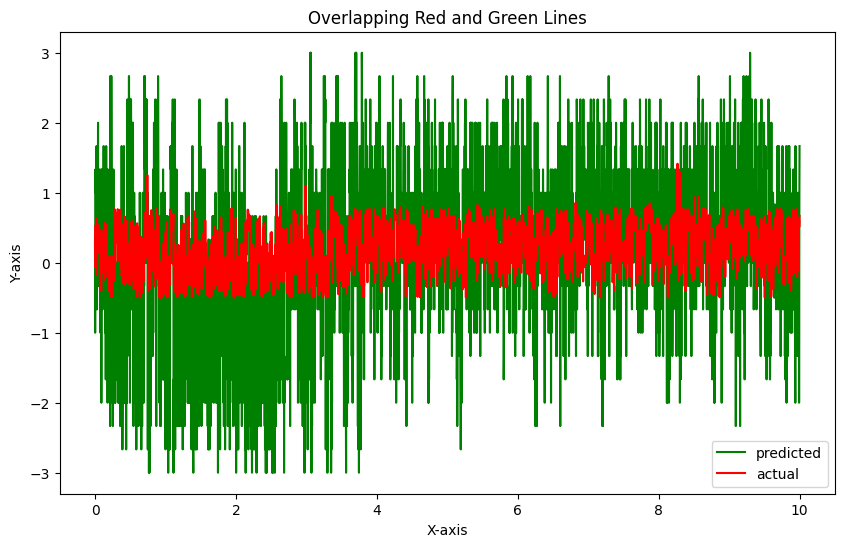

In [84]:
import matplotlib.pyplot as plt

# Sample data (replace these with your actual data)
x = np.linspace(0, 10, 4659)  # Assuming you have 4659 data points
y1 = flatten_2d_array(denormPred)      # Replace with your first array data
y2 = flatten_2d_array(modelTestData['Label_denorm'])      # Replace with your second array data

# Create a figure and axis
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot y1 and y2 as overlapping lines
plt.plot(x, y2, color='green', label='predicted')  # Green line for y2
plt.plot(x, y1, color='red', label='actual')    # Red line for y1

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Overlapping Red and Green Lines')

# Add a legend
plt.legend()

# Show the plot
plt.show()

(array([ 311.,  760., 1125., 1459., 1083., 5715., 3116., 1739.,  811.,
         207.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

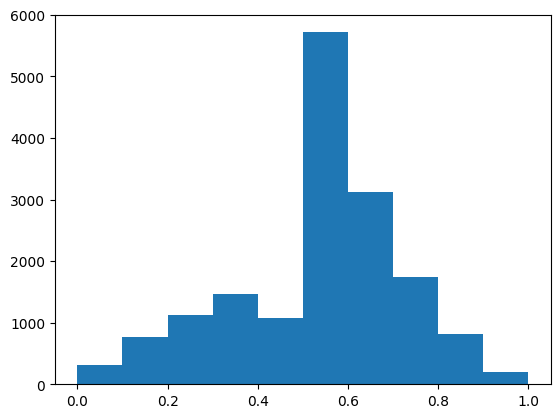

In [85]:
plt.hist(modelTrainData['Label'])

(array([ 311.,  760., 1125., 1459., 1083., 5715., 3116., 1739.,  811.,
         207.]),
 array([-3.        , -2.4000001 , -1.79999995, -1.20000005, -0.60000002,
         0.        ,  0.60000002,  1.20000005,  1.79999995,  2.4000001 ,
         3.        ]),
 <BarContainer object of 10 artists>)

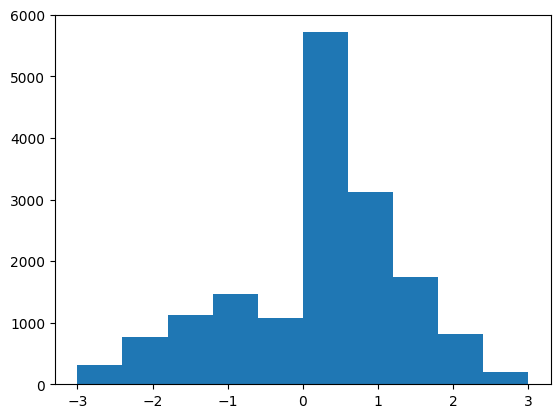

In [86]:
plt.hist(modelTrainData['Label_denorm'])

In [87]:
modelTrainData['Label_denorm']

array([[1.       ],
       [0.6666667],
       [0.       ],
       ...,
       [0.6666667],
       [1.       ],
       [1.       ]], dtype=float32)

In [88]:
modelTrainData['Label']

array([[0.6666667],
       [0.6111111],
       [0.5      ],
       ...,
       [0.6111111],
       [0.6666667],
       [0.6666667]], dtype=float32)

In [89]:
history.history

{'loss': [0.034960512071847916],
 'mean_absolute_error': [0.1411205530166626],
 'val_loss': [0.028429003432393074],
 'val_mean_absolute_error': [0.12733963131904602]}

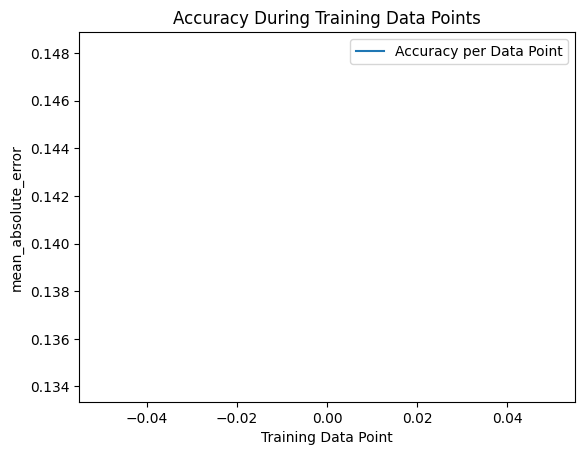

In [90]:
# Access accuracy values for each individual data point
accuracies = history.history['mean_absolute_error']

# Plotting accuracy for each data point
plt.plot(accuracies, label='Accuracy per Data Point')
plt.xlabel('Training Data Point')
plt.ylabel('mean_absolute_error')
plt.title('Accuracy During Training Data Points')
plt.legend()
plt.show()

In [91]:
model.save_weights('MultiModal_model_weights.h5')

In [92]:


# Modify the create_combined_model function
def create_combined_ablation_model(acoustic_input_shape, visual_input_shape):
    acoustic_model = create_acoustic_model(acoustic_input_shape)
    video_model = create_video_model(visual_input_shape)

    acoustic_input = tf.keras.layers.Input(shape=acoustic_input_shape)
    visual_input = tf.keras.layers.Input(shape=visual_input_shape)


    # Assuming the output shape of your video_model is (batch_size, video_output_dim)
    visual_output = video_model(visual_input)

    # Assuming the output shape of your acoustic_model is (batch_size, acoustic_output_dim)
    acoustic_output = acoustic_model(acoustic_input)

    # Modify the next lines according to your actual requirements for combining the models
    # For example, flatten the video_output if needed
    visual_output = tf.keras.layers.Flatten()(visual_output)

    # Concatenate the outputs of the three models
    combined_input = tf.keras.layers.Concatenate()([acoustic_output, visual_output])
    # x = tf.keras.layers.Dense(500, activation='relu')(combined_input)
    # x = tf.keras.layers.Dense(250, activation='sigmoid')(x)
    x = tf.keras.layers.Dense(128, activation='sigmoid')(combined_input)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[acoustic_input, visual_input], outputs=outputs)
    return model


In [93]:
abalationTrainData = [modelTrainData['Data'][0],modelTrainData['Data'][3]]

In [94]:
abalationValData = [modelValData['Data'][0],modelValData['Data'][3]]

In [95]:
ablationModel = create_combined_ablation_model(acoustic_input_shape=(500,74), visual_input_shape=(500,35))
ablationModel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
ablationHistory = ablationModel.fit(
    abalationTrainData,
    modelTrainData['Label'],
    # batch_size=1,
    epochs=1,
    verbose=1,
    validation_data=(abalationValData,modelValData['Label'])
)



2023-08-25 19:35:12.049637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - ETA: 0s - loss: 0.0367 - mean_absolute_error: 0.1441

2023-08-25 19:35:44.550414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - 35s 66ms/step - loss: 0.0367 - mean_absolute_error: 0.1441 - val_loss: 0.0282 - val_mean_absolute_error: 0.1256


In [113]:
ablationModel.save_weights('ablation_model_weights.h5')

In [97]:
abalationTestData = [modelTestData['Data'][0],modelTestData['Data'][3]]

In [98]:
abrPredictions = ablationModel.predict(abalationTestData)

2023-08-25 19:35:48.593529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 3s 20ms/step


In [99]:
denormAbrPred = np.array([[minmax_denormalize(arr[0], label_min, label_max)] for arr in abrPredictions])

In [100]:
metricsAbr = run_metrices(modelTestData['Label_denorm'],denormAbrPred)

# Print the computed metrics
print("Pearson Correlation:", metricsAbr['Correlation'])
print("Acc-7:", metricsAbr['Acc-7'])
print("Acc-2:", metricsAbr['Acc-2'])
print("F1 Score:", metricsAbr['F1'])

print("Mean Squared Error:", metricsAbr['mse'])
print("Mean Absolute Error:", metricsAbr['mae'])

Pearson Correlation: 0.2550782381497157
Acc-7: 0.3788366602275166
Acc-2: 0.6690276883451385
F1 Score: 0.777232013868824
Mean Squared Error: 1.1601294
Mean Absolute Error: 0.8109587


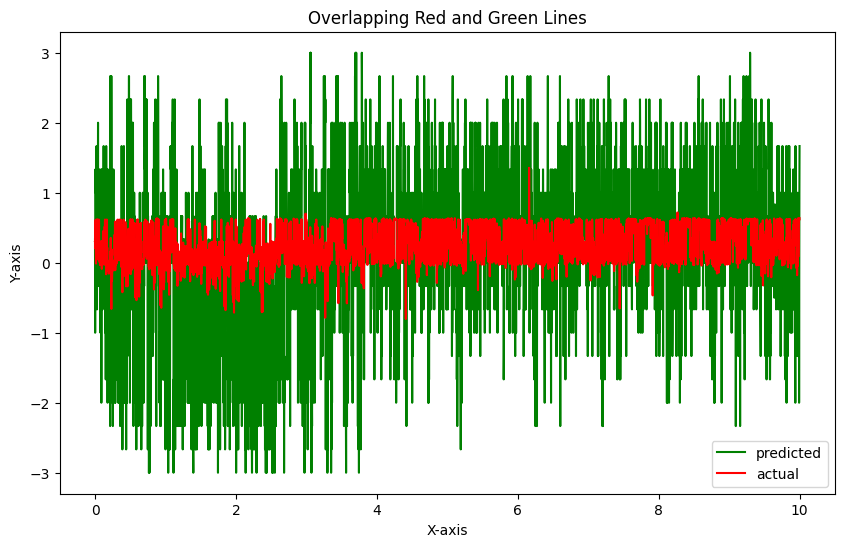

In [101]:
import matplotlib.pyplot as plt

# Sample data (replace these with your actual data)
x = np.linspace(0, 10, 4659)  # Assuming you have 4659 data points
y1 = flatten_2d_array(denormAbrPred)      # Replace with your first array data
y2 = flatten_2d_array(modelTestData['Label_denorm'])      # Replace with your second array data

# Create a figure and axis
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot y1 and y2 as overlapping lines
plt.plot(x, y2, color='green', label='predicted')  # Green line for y2
plt.plot(x, y1, color='red', label='actual')    # Red line for y1

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Overlapping Red and Green Lines')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [102]:
ablationHistory.history

{'loss': [0.036738015711307526],
 'mean_absolute_error': [0.14411334693431854],
 'val_loss': [0.02821439877152443],
 'val_mean_absolute_error': [0.1256094127893448]}

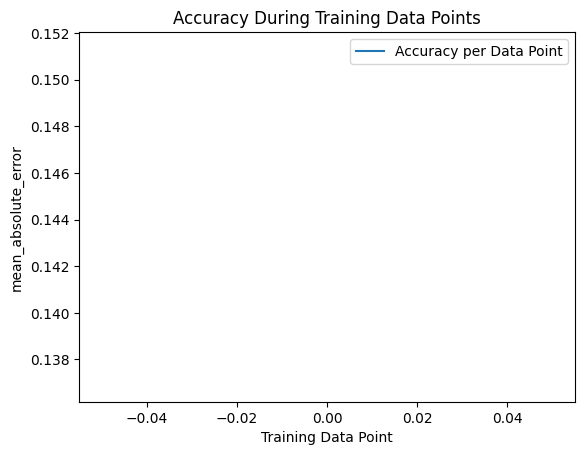

In [103]:
# Access accuracy values for each individual data point
accuracies = ablationHistory.history['mean_absolute_error']

# Plotting accuracy for each data point
plt.plot(accuracies, label='Accuracy per Data Point')
plt.xlabel('Training Data Point')
plt.ylabel('mean_absolute_error')
plt.title('Accuracy During Training Data Points')
plt.legend()
plt.show()

In [104]:
# model.load_weights('model_weights.h5')

In [105]:


# Modify the create_combined_model function
def create_combined_ablation_vedio_model(visual_input_shape):
    video_model = create_video_model(visual_input_shape)

    visual_input = tf.keras.layers.Input(shape=visual_input_shape)


    # Assuming the output shape of your video_model is (batch_size, video_output_dim)
    visual_output = video_model(visual_input)


    # Modify the next lines according to your actual requirements for combining the models
    # For example, flatten the video_output if needed
    visual_output = tf.keras.layers.Flatten()(visual_output)

    # Concatenate the outputs of the three models
    # combined_input = tf.keras.layers.Concatenate()([visual_output])
    # x = tf.keras.layers.Dense(500, activation='relu')(visual_output)
    # x = tf.keras.layers.Dense(250, activation='sigmoid')(combined_input)
    x = tf.keras.layers.Dense(128, activation='sigmoid')(visual_output)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[visual_input], outputs=outputs)
    return model


In [106]:

ablationVedioModel = create_combined_ablation_vedio_model(visual_input_shape=(500,35))
ablationVedioModel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
ablationVedioHistory = ablationVedioModel.fit(
    [abalationTrainData[1]],
    modelTrainData['Label'],
    # batch_size=1,
    epochs=1,
    verbose=1,
    validation_data=([abalationValData[1]],modelValData['Label'])
)



2023-08-25 19:35:52.992864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.1422

2023-08-25 19:36:05.249184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - 14s 24ms/step - loss: 0.0358 - mean_absolute_error: 0.1422 - val_loss: 0.0296 - val_mean_absolute_error: 0.1280


In [114]:
ablationVedioModel.save_weights('ablation_vadio_model_weights.h5')

In [107]:
abrVedPredictions = ablationVedioModel.predict(abalationTestData[1])
denormAbrVedPred = np.array([[minmax_denormalize(arr[0], label_min, label_max)] for arr in abrVedPredictions])
metricsAbrVed = run_metrices(modelTestData['Label_denorm'],denormAbrVedPred)

# Print the computed metrics
print("Pearson Correlation:", metricsAbrVed['Correlation'])
print("Acc-7:", metricsAbrVed['Acc-7'])
print("Acc-2:", metricsAbrVed['Acc-2'])
print("F1 Score:", metricsAbrVed['F1'])

print("Mean Squared Error:", metricsAbrVed['mse'])
print("Mean Absolute Error:", metricsAbrVed['mae'])

2023-08-25 19:36:06.891150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 2s 10ms/step
Pearson Correlation: 0.19600472306156055
Acc-7: 0.41232024039493453
Acc-2: 0.5400300493668169
F1 Score: 0.6094404957171496
Mean Squared Error: 1.196168
Mean Absolute Error: 0.8240189


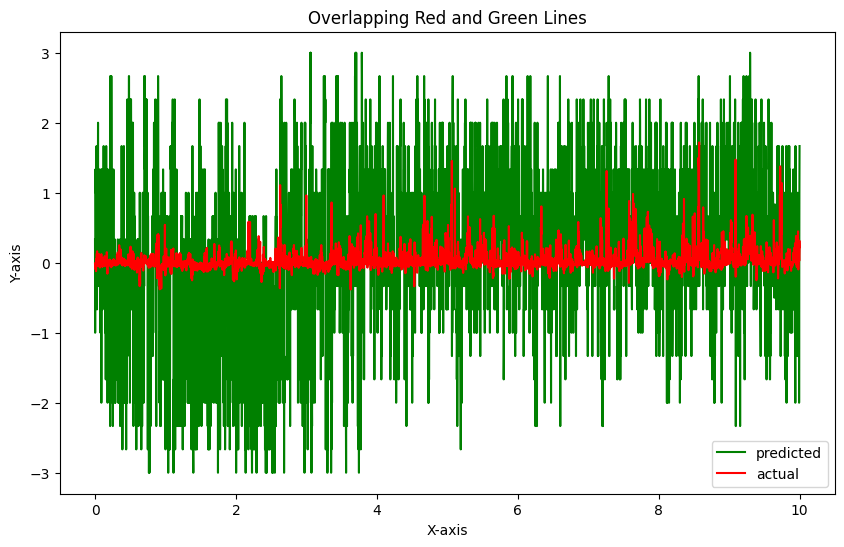

In [108]:
# Sample data (replace these with your actual data)
x = np.linspace(0, 10, 4659)  # Assuming you have 4659 data points
y1 = flatten_2d_array(denormAbrVedPred)      # Replace with your first array data
y2 = flatten_2d_array(modelTestData['Label_denorm'])      # Replace with your second array data

# Create a figure and axis
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot y1 and y2 as overlapping lines
plt.plot(x, y2, color='green', label='predicted')  # Green line for y2
plt.plot(x, y1, color='red', label='actual')    # Red line for y1

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Overlapping Red and Green Lines')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [109]:


# Modify the create_combined_model function
def create_combined_ablation_audio_model(acoustic_input_shape):
    acoustic_model = create_acoustic_model(acoustic_input_shape)

    acoustic_input = tf.keras.layers.Input(shape=acoustic_input_shape)


    # Assuming the output shape of your acoustic_model is (batch_size, acoustic_output_dim)
    acoustic_output = acoustic_model(acoustic_input)


    # Concatenate the outputs of the three models
    # combined_input = tf.keras.layers.Concatenate()([visual_output])
    # x = tf.keras.layers.Dense(500, activation='relu')(visual_output)
    # x = tf.keras.layers.Dense(250, activation='sigmoid')(x)
    x = tf.keras.layers.Dense(128, activation='sigmoid')(acoustic_output)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=[acoustic_input], outputs=outputs)
    return model


In [110]:

ablationAudioModel = create_combined_ablation_audio_model(acoustic_input_shape=(500,74))
ablationAudioModel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
ablationAudioHistory = ablationAudioModel.fit(
    [abalationTrainData[0]],
    modelTrainData['Label'],
    # batch_size=1,
    epochs=1,
    verbose=1,
    validation_data=([abalationValData[0]],modelValData['Label'])
)



2023-08-25 19:36:10.814490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - ETA: 0s - loss: 0.0415 - mean_absolute_error: 0.1506

2023-08-25 19:36:31.897040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - 23s 42ms/step - loss: 0.0415 - mean_absolute_error: 0.1506 - val_loss: 0.0303 - val_mean_absolute_error: 0.1300


In [115]:
ablationAudioModel.save_weights('ablation_audio_model_weights.h5')

In [111]:
abrAudPredictions = ablationAudioModel.predict(abalationTestData[0])
denormAbrAudPred = np.array([[minmax_denormalize(arr[0], label_min, label_max)] for arr in abrAudPredictions])
metricsAbrAud = run_metrices(modelTestData['Label_denorm'],denormAbrAudPred)

# Print the computed metrics
print("Pearson Correlation:", metricsAbrAud['Correlation'])
print("Acc-7:", metricsAbrAud['Acc-7'])
print("Acc-2:", metricsAbrAud['Acc-2'])
print("F1 Score:", metricsAbrAud['F1'])

print("Mean Squared Error:", metricsAbrAud['mse'])
print("Mean Absolute Error:", metricsAbrAud['mae'])

2023-08-25 19:36:34.434936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 2s 13ms/step
Pearson Correlation: 0.08373135654470475
Acc-7: 0.4125348787293411
Acc-2: 0.6087143163769049
F1 Score: 0.7266456740140951
Mean Squared Error: 1.2286615
Mean Absolute Error: 0.8434142


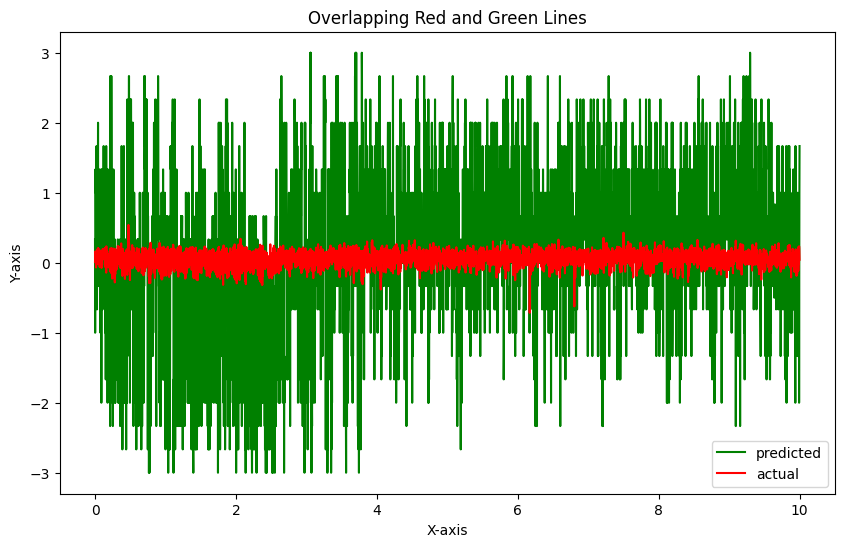

In [112]:
# Sample data (replace these with your actual data)
x = np.linspace(0, 10, 4659)  # Assuming you have 4659 data points
y1 = flatten_2d_array(denormAbrAudPred)      # Replace with your first array data
y2 = flatten_2d_array(modelTestData['Label_denorm'])      # Replace with your second array data

# Create a figure and axis
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot y1 and y2 as overlapping lines
plt.plot(x, y2, color='green', label='predicted')  # Green line for y2
plt.plot(x, y1, color='red', label='actual')    # Red line for y1

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Overlapping Red and Green Lines')

# Add a legend
plt.legend()

# Show the plot
plt.show()